In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 14 18:24:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
#LOAD CLIP
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 64 kB 2.4 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=c112ef4f476e1dbb440a196f108c6e069c1b2b4b40617758009ece1d8e94c819
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3gvn2t53
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-3gvn2t53
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369106 sha256=ad2c1f44fd07f5d128fda8f783981c584061a5284b5afef6d13d1a1ceb548660
  Stored in directory: /tmp/pip-ephem-wheel-cache-mnr3nqqq/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import clip
import numpy as np
import torch

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
%cd /content/drive/MyDrive/RESEARCH/CUB_200_2011/CUB_200_2011/

/content/drive/MyDrive/RESEARCH/CUB_200_2011/CUB_200_2011


In [ ]:
!ls

attributes	    image_class_labels.txt  parts
bounding_boxes.txt  images		    README
classes.txt	    images.txt		    train_test_split.txt


In [ ]:
file_path = '/content/drive/MyDrive/RESEARCH/CUB_200_2011/CUB_200_2011/'

In [ ]:
image_list = file_path + 'images.txt' #index to image file name
image_class_labels =  file_path + 'image_class_labels.txt' #index to class index
classes = file_path + 'classes.txt' #class index to class name
split = file_path + 'train_test_split.txt' #image index & 0 or 1(train)

# data structures

image_path[id] = path

image_label[id] = class label

class_to_imageid[class id] = list of images belonging to class

In [ ]:
from collections import defaultdict

# get image path from images.txt
image_path = {}
with open(image_list, 'r') as image_list_f:
  for line in image_list_f:
    id, path = line.strip().split(" ")
    image_path[int(id) -1 ] = path
print(len(image_path)) #11788


image_label = {}
class_to_imageids = defaultdict(list)
# get image label from image_class_labels.txt
with open(image_class_labels, 'r') as image_class_labels_f:
  for line in image_class_labels_f:
    id, label = line.strip().split(" ")
    image_label[int(id)-1] = int(label) -1
    class_to_imageids[int(label)-1].append(int(id)-1)

print(len(image_label)) #11788

train_id_list = []
test_id_list = []


#get train test split id from train_test_split.txt
with open(split, 'r') as split_f:
  for line in split_f:
    id, is_train = line.strip().split(" ")
    is_train = int(is_train)
    if is_train:
      train_id_list.append(int(id)-1)
    else:
      test_id_list.append(int(id)-1)

print(len(train_id_list),len(test_id_list)) #5994 5794


11788
11788
5994 5794


In [ ]:
file_path = '/content/drive/MyDrive/RESEARCH/CUB_200_2011/CUB_200_2011/'
image_path[0]

'001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg'

In [ ]:
classes_desc = []
classes_name = []
classes_dict = {}
descriptions = {}
# get class names from classes.txt
with open(classes, 'r') as classes_f:
  for line in classes_f:
    cid, class_name = line.strip().split(" ")
    class_name = class_name.split(".")[1].lower()
    class_name_p = class_name.replace("_", " ")
    description = 'a photo of {} bird'.format(class_name_p)

    classes_desc.append(description)
    classes_name.append(class_name_p)

    descriptions[int(cid)-1] = description
    classes_dict[int(cid)-1] = class_name
    #print(descriptions)

NUM_CLASSES = len(classes_dict)
len(classes_name) #200
print(classes_name[199]) #id off by 1
print(classes_desc[199]) #id off by 1
print(classes_dict[199])

common yellowthroat
a photo of common yellowthroat bird
common_yellowthroat


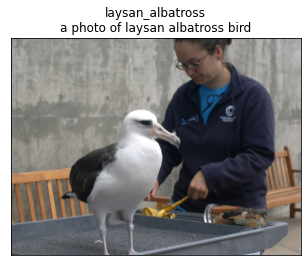

In [ ]:
def display_image(image_id):
  full_path = os.path.join(file_path, 'images', image_path[image_id])
  # image
  image = Image.open(full_path).convert('RGB')  # (C, H, W)
  #name
  name = descriptions[image_label[image_id]]
  plt.imshow(image)
  plt.title(f"{classes_dict[image_label[image_id]]}\n{name}")
  plt.xticks([])
  plt.yticks([])
  return

display_image(0)
display_image(20)
display_image(61)
display_image(62)
display_image(70)

In [ ]:
#building sample list FOR CLASS
import random

N = 8
#sample 5 species
class_sample = random.sample(range(1,200), N)
print(class_sample)

train_list = []
texts = []
#sample 5 image from each species
for id in class_sample:
  rand = random.sample(class_to_imageids[id],5)
  [train_list.append(item) for item in rand]
  texts.append(descriptions[id])

#shuffle the images
random.seed(0)
random.shuffle(train_list)

print(len(train_list))
print(len(texts))
print(train_list)

[6666, 207, 3858, 8240, 199, 858, 10877, 1326, 6638, 8262, 7807, 7849, 3889, 3852, 3883, 10849, 8241, 10863, 8277, 893, 7846, 10860, 6665, 1310, 7838, 6663, 10887, 7847, 184, 842, 3892, 1323, 850, 230, 1322, 1297, 883, 6658, 213, 8235]


# CLIP

## Image preprocessing

In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f3718f46ef0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
len(test_id_list)

5794

## Build features
We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

# all of CUB

image_input = preprocess(image).unsqueeze(0).to(device) #torch.Size([1, 3, 224, 224])
images = [img, img..] image_input = torch.tensor(np.stack(images)).cuda() 
np.stack(images)--> converts to numpy array
conver to tensor & send to cuda


preprocess(image).shape #(3,224,224)
preprocess(image).unsqueeze(0).shape(1,3,224,224)
unsqueeze adds a dimension

text_inputs.shape #200x77



In [ ]:
def process_image(image_id):
  full_path = os.path.join(file_path, 'images', image_path[image_id])
  # image
  image = Image.open(full_path).convert('RGB')  # (C, H, W)
  #name

  return preprocess(image)

def process_image_list(image_id_list):
  processed_image_list = []
  total = len(image_id_list)
  count= 0
  for image_id in image_id_list:
    full_path = os.path.join(file_path, 'images', image_path[image_id])

    # image
    image = Image.open(full_path).convert('RGB')  # (C, H, W)
    processed_image_list.append(preprocess(image))
    count +=1
    if(count %10 ==0):
      print(count)
  return processed_image_list

#processed_list = process_image_list(test_list)
#image_input = torch.tensor(np.stack(processed_list)).cuda()

In [ ]:
# Prepare the inputs--> need to predict one at a time
import random
random.seed(0)
test_list = test_id_list
random.shuffle(test_list)


In [ ]:
#prepare the text input-- should be 200 by 77
text_inputs = clip.tokenize(classes_desc).cuda()
print(text_inputs.shape)


torch.Size([200, 77])


In [ ]:
#one at a time
device = "cuda" if torch.cuda.is_available() else "cpu"

top1_corr = 0
topk_corr = 0
image_id = 0
count = 0

with torch.no_grad():
  text_features = model.encode_text(text_inputs).float()
  text_features /= text_features.norm(dim=-1, keepdim=True)

  for image_id in test_list:
    processed_image = process_image(image_id)
    image_input = processed_image.unsqueeze(0).to(device)

    # Calculate features
    image_features = model.encode_image(image_input).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    values, indices = similarity[0].topk(5, dim=-1)

    values = values.cpu().numpy()
    indices = indices.cpu().numpy() #indices goes from 0 to 199

    act = image_label[image_id]
    print("\nactual label: ", classes_name[act])
    print("Top predictions:\n")
    for value, index in zip(values, indices):
      print(f"{classes_name[index]:>16s}: {100 * value.item():.2f}%")

    if(indices[0] == act):
      top1_corr+=1

    for k in indices:
      if k == act:
        topk_corr +=1
        break
    count +=1

    if(count %10 ==0):
      print(count, top1_corr, topk_corr)
    

top1_acc = top1_corr/(count*1.0)
topk_acc = topk_corr/(count*1.0)
print(count, top1_corr, topk_corr)
print(count, top1_acc, topk_acc)

5794 3058 4806
5794 0.5277873662409389 0.8294787711425613


results:

5794 3058 4806
5794 

top1: 
0.5277873662409389 

top5: 
0.8294787711425613

With "This is ___"
5794 3047 4801
5794 

top1: 0.5258888505350362 

top5: 0.82861580945806

#promp engineering
adding "this is" to text input

In [ ]:
#prepare the text input-- should be 200 by 77
text_inputs2 = clip.tokenize(["This is " + desc for desc in classes_desc]).cuda()
print(text_inputs2.shape)

torch.Size([200, 77])


In [ ]:
#one at a time
device = "cuda" if torch.cuda.is_available() else "cpu"

top1_corr = 0
topk_corr = 0
image_id = 0
count = 0

with torch.no_grad():
  text_features = model.encode_text(text_inputs2).float()
  text_features /= text_features.norm(dim=-1, keepdim=True)

  for image_id in test_list:
    processed_image = process_image(image_id)
    image_input = processed_image.unsqueeze(0).to(device)

    # Calculate features
    image_features = model.encode_image(image_input).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    values, indices = similarity[0].topk(5, dim=-1)

    values = values.cpu().numpy()
    indices = indices.cpu().numpy() #indices goes from 0 to 199

    act = image_label[image_id]
    print("\nactual label: ", classes_name[act])
    print("Top predictions:\n")
    for value, index in zip(values, indices):
      print(f"{classes_name[index]:>16s}: {100 * value.item():.2f}%")

    if(indices[0] == act):
      top1_corr+=1

    for k in indices:
      if k == act:
        topk_corr +=1
        break
    count +=1

    if(count %10 ==0):
      print(count, top1_corr, topk_corr)
    

top1_acc = top1_corr/(count*1.0)
topk_acc = topk_corr/(count*1.0)
print(count, top1_corr, topk_corr)
print(count, top1_acc, topk_acc)

Streaming output truncated to the last 5000 lines.
 mangrove cuckoo: 6.07%
        sayornis: 2.56%

actual label:  hooded oriole
Top predictions:

   hooded oriole: 19.13%
prothonotary warbler: 13.87%
golden winged warbler: 10.82%
  orchard oriole: 7.35%
evening grosbeak: 5.82%

actual label:  white breasted kingfisher
Top predictions:

white breasted kingfisher: 69.97%
        sayornis: 13.23%
green kingfisher: 6.25%
red breasted merganser: 4.26%
ringed kingfisher: 1.52%

actual label:  green violetear
Top predictions:

 green violetear: 52.91%
ruby throated hummingbird: 25.80%
anna hummingbird: 12.99%
rufous hummingbird: 3.57%
       green jay: 0.93%

actual label:  least flycatcher
Top predictions:

acadian flycatcher: 11.77%
black capped vireo: 8.28%
    pine warbler: 8.20%
philadelphia vireo: 7.32%
yellow throated vireo: 6.95%

actual label:  boat tailed grackle
Top predictions:

boat tailed grackle: 83.81%
       fish crow: 2.61%
groove billed ani: 2.56%
 rusty blackbird: 2.31%
 

# using contrastive explanation

this is a bird with red feathers

-----
50% accuracy with description
120 60 0
120 0.5

51% accuracy with description:

cal_text= "this is a bird with red spot near the tip of its lower mandible"

ring_text = "this is a bird with with black ring near the tip of its bill"



-----
cal_text= "this is a bird with red spot near its bill"

ring_text = "this is a bird with with black ring near its bill"

0.48333333333333334
48.3% acccuracy


cal_text= "this is a bird with red spot near its gull"

ring_text = "this is a bird with with black ring near its gull"

120 59 0
120 0.49166666666666664

-----
70% accuracy with just class "this is a california gull"
120 84 0
120 0.7

In [ ]:
cal_gull =58
ring_gull = 63
print(classes_name[cal_gull], classes_name[ring_gull])


nle = "“Ring-billed gull has a bill with a black ring near the tip while California gull has a red spot near the tip of lower mandible”,"
cal_text= "this is a bird with red spot near the tip of its lower mandible"
ring_text = "this is a bird with with black ring near the tip of its bill"

cal_text= "this is a bird with red spot near the tip of its gull"
ring_text = "this is a bird with with black ring near the tip of its gull"

cal_text= "this is a " + classes_name[cal_gull]
ring_text = "this is a " + classes_name[ring_gull]

texts = [cal_text, ring_text]

nle_description = {}
nle_description[cal_gull] = cal_text
nle_description[ring_gull] = ring_text

test_label = [58, 63]
test_list = class_to_imageids[cal_gull] + class_to_imageids[ring_gull]
print(texts)

In [ ]:
text_inputs3 = clip.tokenize(texts).cuda()
print(text_inputs3.shape)


torch.Size([2, 77])


In [ ]:
classes_name[image_label[test_list[0]]]

'california gull'

In [ ]:
#one at a time
device = "cuda" if torch.cuda.is_available() else "cpu"

top1_corr = 0
topk_corr = 0
image_id = 0
count = 0

with torch.no_grad():
  text_features = model.encode_text(text_inputs3).float()
  text_features /= text_features.norm(dim=-1, keepdim=True)

  for image_id in test_list:
    processed_image = process_image(image_id)
    image_input = processed_image.unsqueeze(0).to(device)

    # Calculate features
    image_features = model.encode_image(image_input).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    values, indices = similarity[0].topk(1, dim=-1)

    values = values.cpu().numpy()
    indices = indices.cpu().numpy() #indices goes from 0 to 199

    act = image_label[image_id]
    pred = test_label[indices[0]]

    print("\nactual label: ", classes_name[act])

    print("Top predictions:\n")
    for value, index in zip(values, indices):
      print(f"{classes_name[test_label[index]]:>16s}: {100 * value.item():.2f}%")

    count +=1
    if(pred == act):
      top1_corr+=1
    
    

#top1_acc = top1_corr/(count*1.0)
#topk_acc = topk_corr/(count*1.0)
print(count, top1_corr, topk_corr)
print(count, top1_corr/(count*1.0))
#print(count, top1_acc, topk_acc)


actual label:  california gull
Top predictions:

ring billed gull: 54.95%

actual label:  california gull
Top predictions:

 california gull: 85.14%

actual label:  california gull
Top predictions:

 california gull: 56.89%

actual label:  california gull
Top predictions:

 california gull: 80.14%

actual label:  california gull
Top predictions:

 california gull: 80.81%

actual label:  california gull
Top predictions:

 california gull: 67.23%

actual label:  california gull
Top predictions:

 california gull: 66.38%

actual label:  california gull
Top predictions:

 california gull: 65.22%

actual label:  california gull
Top predictions:

 california gull: 60.14%

actual label:  california gull
Top predictions:

 california gull: 74.13%

actual label:  california gull
Top predictions:

 california gull: 71.52%

actual label:  california gull
Top predictions:

 california gull: 76.41%

actual label:  california gull
Top predictions:

 california gull: 78.45%

actual label:  californi

# can CLIP distinguish between red and grey neck?

black footed albatross bird
120 112 0.9333333333333333

laysan albatross bird

93% accuracy with class name

75% accuracy with attribute

sp0_text= "this is a bird with grey neck"
sp1_text = "this is a bird with white neck"



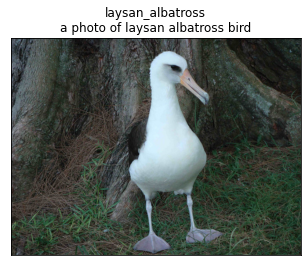

In [ ]:
display_image(0)
display_image(1)
display_image(61)


In [ ]:
species0 = 0
species1 = 1
print(classes_name[species0], classes_name[species1])

sp0_text= "this is a " + classes_name[species0]
sp1_text = "this is a " + classes_name[species1]

texts = [sp0_text, sp1_text]

test_label = [0, 1]
test_list = class_to_imageids[species0] + class_to_imageids[species1]
print(texts)
print(len(test_list))

text_inputs3 = clip.tokenize(texts).cuda()
count, top1_acc = clip_top1(text_inputs3)
print(count, top1_acc, top1_acc/(count*1.0))

120 112 0.9333333333333333


In [ ]:
species0 = 0 2
species1 = 1
print(classes_name[species0], classes_name[species1])

sp0_text= "this is a bird with grey neck"
sp1_text = "this is a bird with white neck"

texts = [sp0_text, sp1_text]

test_label = [0, 1]
test_list = class_to_imageids[species0] + class_to_imageids[species1]
print(texts)
print(len(test_list))

text_inputs3 = clip.tokenize(texts).cuda()
count, top1_acc = clip_top1(text_inputs3)
print(count, top1_acc, top1_acc/(count*1.0))

In [ ]:
#one at a time
def clip_top1(text_inputs):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  top1_corr = 0
  topk_corr = 0
  image_id = 0
  count = 0

  with torch.no_grad():
    text_features = model.encode_text(text_inputs).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for image_id in test_list:
      processed_image = process_image(image_id)
      image_input = processed_image.unsqueeze(0).to(device)

      # Calculate features
      image_features = model.encode_image(image_input).float()

      image_features /= image_features.norm(dim=-1, keepdim=True)
      similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

      values, indices = similarity[0].topk(1, dim=-1)

      values = values.cpu().numpy()
      indices = indices.cpu().numpy() #indices goes from 0 to 199

      act = image_label[image_id]
      pred = test_label[indices[0]]

      print("\nactual label: ", classes_name[act])

      print("Top predictions:\n")
      for value, index in zip(values, indices):
        print(f"{classes_name[test_label[index]]:>16s}: {100 * value.item():.2f}%")

      count +=1
      if(pred == act):
        top1_corr+=1
  return count, top1_corr

#using attribute level info from dataset about species

species with lowest performance


# generating caption & model with distinct caption
#distinctive caption generation tells you difference between images
#can model tell me difference between classes?

#text summarization with compare & contrast